In [1]:
import quandl
import matplotlib.pyplot as plt
plt.show()
quandl.ApiConfig.api_key = "2DaaDeZYy3iMCzUnxGgM"
%matplotlib inline
%pylab inline
import datetime
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from nltk import word_tokenize, pos_tag
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from difflib import SequenceMatcher
import os
import pickle

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:999: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:999: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/home/ubuntu/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
pylab.rcParams['figure.figsize'] = (15, 9)

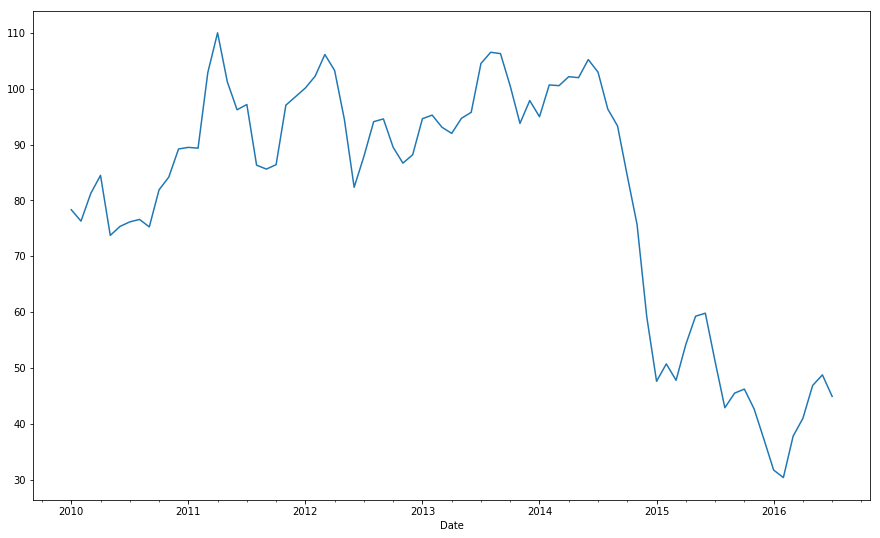

In [3]:
url = "https://www.quandl.com/api/v3/datasets/ODA/POILWTI_USD.csv?start_date=2010-01-01&end_date=2016-08-01"
df_oil = pd.read_csv(url, index_col=0, parse_dates=True).head(1000)
df_oil['Value'].plot()

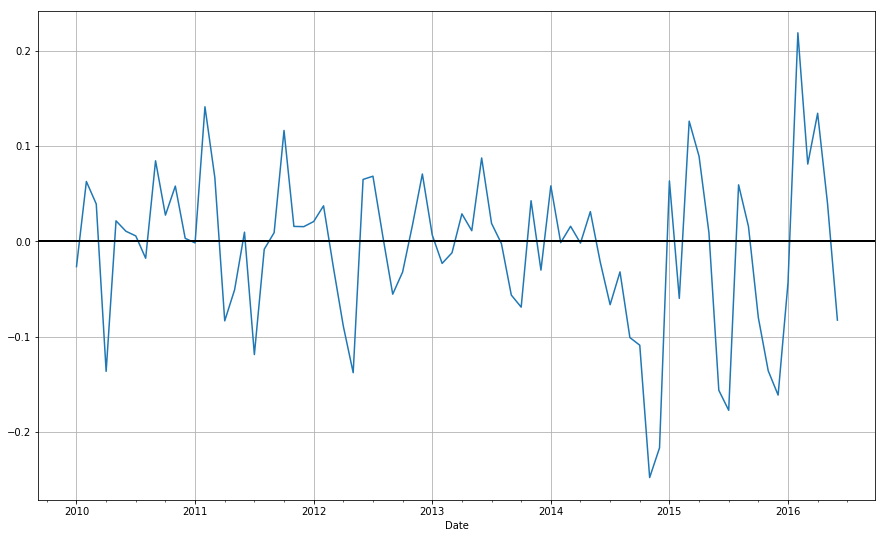

In [4]:
oil_change_monthly =   np.log(df_oil['Value'].shift(1)) - np.log(df_oil['Value']) 
oil_change_monthly.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

In [5]:
oil_change_monthly = oil_change_monthly.dropna()
sorted = oil_change_monthly.sort_values()
df = sorted.iloc[-3:].to_frame()
df1 = sorted.iloc[:3].to_frame()

In [6]:
def get_news_data(date):
    news_data = []
    for year in date:
        for ls in os.listdir('../bnp/Reuters-full-data-set/data'):
                if ls.endswith('.pkl') and ls.startswith(year):
                    with open('../bnp/Reuters-full-data-set/data/' + ls, 'rb') as f:
                        data = pickle.load(f, encoding='latin1')
                        for datum in data:
                            if 'oil' in datum['title'].lower() or 'crude' in datum['title'] or 'WTI' in datum['title']:
                                news_data.append(datum)
    return news_data

def determine_tense_input(sentence):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)

    tense = {}
    tense["future"] = len([word for word in tagged if word[1] == "MD"])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]])
    return(tense)

def get_month_news(date, sentiment):
    print('entered get_month_news', date)
    news_data = get_news_data([date])
    news_df = pd.DataFrame(news_data)
    try:
        news_df = news_df.drop('href', axis=1)
    except:
        pass
    news_df = news_df.drop_duplicates('title',False)
    news_df['tense'] = [ determine_tense_input(i) for i in news_df['title'].values]
    news = []
    sid = SentimentIntensityAnalyzer()
    for idx, item in news_df.iterrows():
        if len(news) == 0:
            if item['tense']['future'] > 0:
                    news.append(item['title'])
        else:
            if SequenceMatcher(a = item['title'], b = news[-1]).ratio() < 0.7:
                if item['tense']['future'] > 0:
                    ss = sid.polarity_scores(item['title'])
                    if ss[sentiment] > 0:
                        news.append(item['title'])
    return news

In [7]:
positive_return = {}
negative_return = {}
for i, d in enumerate(sorted.index[:3]):
    t = str(d)[:4] + str(d)[5:7]
    positive_return[str(d)[:10]] = {
        'return' : sorted[i],
        'news' : get_month_news(t, 'neg')
    }
for i, d in enumerate(sorted.index[-3:]):
    t = str(d)[:4] + str(d)[5:7]
    negative_return[str(d)[:10]] = {
        'return' : sorted[-i - 1],
        'news' : get_month_news(t, 'pos')
    }

entered get_month_news 201411
entered get_month_news 201412
entered get_month_news 201507
entered get_month_news 201604
entered get_month_news 201102
entered get_month_news 201602


In [8]:
positive_return

{'2014-11-30': {'return': -0.24754723603135087,
  'news': ['Cheap oil may temper cheer over strong Canada third quarter GDP',
   'Speculators increase bets that Brent crude will fall to $65 in first quarter',
   'Oil price drop may drive Europe back to Russian gas next year',
   'Colombian cenbank may hold rate amid oil worries, impact on growth',
   'UPDATE 1-Russian economy minister says 2015 oil price forecast will be cut',
   'Falling oil may frustrate push for Asia LNG spot market',
   'Tiny Emerald Oil says may pull Bakken rig on price dip',
   'Fitch: Lower Oil Prices Will Have Mixed Impact on Commodities',
   "MEDIA-India's oil ministry may direct RIL-KG basin gas users to pay old rate - Economic Times",
   'U.S. shale output could withstand much lower oil prices - hedging expert',
   'Oil price drop could have perverse braking effect on economy',
   'UPDATE 1-Iraqi Kurdistan says sold $3 bln of oil, will pay producers',
   'UPDATE 3-Subsea 7 may cut fleet as fall in oil price 

In [9]:
negative_return

{'2016-04-30': {'return': 0.21871861921885793,
  'news': ['MIDEAST STOCKS-Gulf may edge up as oil recovers; QNB earnings loom',
   'Oil boost could help ECB medicine work',
   'Iran determined to regain oil market share, can handle low price: source',
   'MIDEAST STOCKS-Gulf shares may pull back after oil drops',
   'Lukoil: Russia should continue talks on global oil output freeze',
   'Latam oil producers may help provide rebalancing that Doha could not',
   'New Doha oil deal draft says all OPEC members must join: sources',
   'MIDEAST STOCKS-Gulf bourses may rise on hopes for Doha oil meeting',
   'China stimulus may give temporary boost to gasoil margins: Russell',
   'Canada\'s TD Bank confident oil & gas loan losses will be "manageable"',
   'Oil analysts turn cautiously positive but warn rally may fade: poll',
   "BRIEF-Scotiabank CEO says oil firms' credit lines will be cut",
   'Why Chinaâ\x80\x99s latest power play may roil Russia',
   "Iran urges oil producers to keep discus

In [10]:
# I also tried to get a correlation between returns and number of news articles, hoping to see that 
# that months with greater changes will have a greater count of news_articles but could not find any positive results
# TODO : number of negative articles compared to whether it went up or down. 